In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)

100%|██████████| 218M/218M [00:01<00:00, 117MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1


In [234]:
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Normalize
from torch.optim.lr_scheduler import LambdaLR

plt.style.use('fivethirtyeight')

def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        self.scheduler = None
        self.is_batch_lr_scheduler = False
        self.clipping = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.learning_rates = []
        self.total_epochs = 0

        self.visualization = {}
        self.handles = {}

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients
            loss.backward()

            if callable(self.clipping):
                self.clipping()

            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        n_batches = len(data_loader)
        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for i, (x_batch, y_batch) in enumerate(data_loader):
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

            if not validation:
                self._mini_batch_schedulers(i / n_batches)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            self._epoch_schedulers(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title('{} #{}'.format(title, j), fontsize=12)
            ax.set_ylabel(
                '{}\n{}x{}'.format(layer_name, *np.atleast_2d(image).shape),
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else '\nLabel: {}'.format(y[j])
            xlabel2 = '' if yhat is None else '\nPredicted: {}'.format(yhat[j])
            xlabel = '{}{}'.format(xlabel1, xlabel2)
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # The weights have channels_out (filter), channels_in, H, W shape
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels, figsize=size)
                axes = np.atleast_2d(axes).reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    StepByStep._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name='Filter #{}'.format(i),
                        title='Channel' if (i == 0) else None
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = list(filter(lambda l: l in self.visualization.keys(), layers))
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1 for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images, figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                StepByStep._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] if is_vector else '{}\nfil#{}'.format(layers[i], row-start_row),
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
               isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (torch.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)

    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = StepByStep.loader_apply(loader, StepByStep.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                           'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def capture_gradients(self, layers_to_hook):
        if not isinstance(layers_to_hook, list):
            layers_to_hook = [layers_to_hook]

        modules = list(self.model.named_modules())
        self._gradients = {}

        def make_log_fn(name, parm_id):
            def log_fn(grad):
                self._gradients[name][parm_id].append(grad.tolist())
                return
            return log_fn

        for name, layer in self.model.named_modules():
            if name in layers_to_hook:
                self._gradients.update({name: {}})
                for parm_id, p in layer.named_parameters():
                    if p.requires_grad:
                        self._gradients[name].update({parm_id: []})
                        log_fn = make_log_fn(name, parm_id)
                        self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
        return

    def capture_parameters(self, layers_to_hook):
        if not isinstance(layers_to_hook, list):
            layers_to_hook = [layers_to_hook]

        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules}

        self._parameters = {}

        for name, layer in modules:
            if name in layers_to_hook:
                self._parameters.update({name: {}})
                for parm_id, p in layer.named_parameters():
                    self._parameters[name].update({parm_id: []})

        def fw_hook_fn(layer, inputs, outputs):
            name = layer_names[layer]
            for parm_id, parameter in layer.named_parameters():
                self._parameters[name][parm_id].append(parameter.tolist())

        self.attach_hooks(layers_to_hook, fw_hook_fn)
        return

    def set_lr_scheduler(self, scheduler):
        # Makes sure the scheduler in the argument is assigned to the
        # optimizer we're using in this class
        if scheduler.optimizer == self.optimizer:
            self.scheduler = scheduler
            if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
                isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
                isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
                self.is_batch_lr_scheduler = True
            else:
                self.is_batch_lr_scheduler = False

    def _epoch_schedulers(self, val_loss):
        if self.scheduler:
            if not self.is_batch_lr_scheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

    def _mini_batch_schedulers(self, frac_epoch):
        if self.scheduler:
            if self.is_batch_lr_scheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
                    self.scheduler.step(self.total_epochs + frac_epoch)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

    def set_clip_grad_value(self, clip_value):
        self.clipping = lambda: nn.utils.clip_grad_value_(self.model.parameters(), clip_value=clip_value)

    def set_clip_grad_norm(self, max_norm, norm_type=2):
        self.clipping = lambda: nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=max_norm, norm_type=norm_type)

    def set_clip_backprop(self, clip_value):
        if self.clipping is None:
            self.clipping = []
        for p in self.model.parameters():
            if p.requires_grad:
                func = lambda grad: torch.clamp(grad, -clip_value, clip_value)
                handle = p.register_hook(func)
                self.clipping.append(handle)

    def remove_clip(self):
        if isinstance(self.clipping, list):
            for handle in self.clipping:
                handle.remove()
        self.clipping = None

In [235]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from PIL import Image
# from stepbystep.v2 import StepByStep
from torchvision.transforms import ToPILImage
from sklearn.linear_model import LinearRegression
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

def EWMA(past_value, current_value, alpha):
    return (1 - alpha) * past_value + alpha * current_value

def calc_ewma(values, period):
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

def correction(averaged_value, beta, steps):
    return averaged_value / (1 - (beta ** steps))

def figure1(folder='rps'):
    paper = Image.open(f'{folder}/paper/paper02-089.png')
    rock = Image.open(f'{folder}/rock/rock06ck02-100.png')
    scissors = Image.open(f'{folder}/scissors/testscissors02-006.png')

    images = [rock, paper, scissors]
    titles = ['Rock', 'Paper', 'Scissors']

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    for ax, image, title in zip(axs, images, titles):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig

def calc_corrected_ewma(values, period):
    ewma = calc_ewma(values, period)

    alpha = 2 / (period + 1)
    beta = 1 - alpha

    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)

    return np.array(result)

def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = ['Cat', 'Dog']
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

def plot_dist(ax, distrib_outputs, p):
    ax.hist(distrib_outputs, bins=np.linspace(0, 20, 21))
    ax.set_xlabel('Sum of Adjusted Outputs')
    ax.set_ylabel('# of Scenarios')
    ax.set_title('p = {:.2f}'.format(p))
    ax.set_ylim([0, 500])
    mean_value = distrib_outputs.mean()
    ax.plot([mean_value, mean_value], [0, 500], c='r', linestyle='--', label='Mean = {:.2f}'.format(mean_value))
    ax.legend()

def figure7(p, distrib_outputs):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plot_dist(ax, distrib_outputs, p)
    fig.tight_layout()
    return fig

def figure8(ps=(0.1, 0.3, 0.5, 0.9)):
    spaced_points = torch.linspace(.1, 1.1, 11)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for ax, p in zip(axs.flat, ps):
        torch.manual_seed(17)
        distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                                 weight=torch.ones(11), bias=torch.tensor(0))
                                        for _ in range(1000)])
        plot_dist(ax, distrib_outputs, p)
        ax.label_outer()
    fig.tight_layout()
    return fig

def figure9(first_images, seed=17, p=.33):
    torch.manual_seed(seed)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(ToPILImage()(first_images[0]))
    axs[0].set_title('Original Image')
    axs[0].grid(False)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(ToPILImage()(F.dropout(first_images[:1], p=p)[0]))
    axs[1].set_title('Regular Dropout')
    axs[1].grid(False)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].imshow(ToPILImage()(F.dropout2d(first_images[:1], p=p)[0]))
    axs[2].set_title('Two-Dimensional Dropout')
    axs[2].grid(False)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    fig.tight_layout()
    return fig

def figure11(losses, val_losses, losses_nodrop, val_losses_nodrop):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses, 'b', label='Training Losses - Dropout')
    axs.plot(val_losses, 'r', label='Validation Losses - Dropout')
    axs.plot(losses_nodrop, 'b--', label='Training Losses - No Dropout')
    axs.plot(val_losses_nodrop, 'r--', label='Validation Losses - No Dropout')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Regularizing Effect')
    fig.legend(loc='lower left')
    fig.tight_layout()
    return fig

def figure15(alpha=1/3, periods=5, steps=10):
    t = np.arange(1, steps+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.bar(t-1, alpha*(1-alpha)**(t-1), label='EWMA')
    ax.bar(t-1, [1/periods]*periods + [0]*(10-periods), color='r', alpha=.3, label='MA')
    ax.set_xticks(t-1)
    ax.grid(False)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Weight')
    ax.set_title(r'$EWMA\ \alpha=\frac{1}{3}$ vs MA (5 periods)')
    ax.legend()
    fig.tight_layout()
    return fig

def ma_vs_ewma(values, periods=19):
    ma19 = pd.Series(values).rolling(min_periods=0, window=periods).mean()
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(values, c='k', label='Temperatures')
    ax.plot(ma19, c='k', linestyle='--', label='MA')
    ax.plot(calc_ewma(values, periods), c='r', linestyle='--', label='EWMA')
    ax.plot(calc_corrected_ewma(values, periods), c='r', linestyle='-', label='Bias-corrected EWMA')
    ax.set_title('MA vs EWMA')
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Days')
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

def figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    ax = axs[0]
    ax.plot(gradients, c='k', label=r'$Gradients$')
    ax.plot(corrected_gradients, c='r', linestyle='-', label=r'$Bias-corrected\ EWMA(grad)$')
    ax.set_title('EWMA for Smoothing')
    ax.set_ylabel('Gradient')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([-1.5, 1.5])
    ax.legend(fontsize=12)

    ax = axs[1]
    ax.plot(1/(np.sqrt(corrected_sq_gradients)+1e-8), c='b', linestyle='-', label=r'$\frac{1}{\sqrt{Bias-corrected\ EWMA(grad^2)}}$')
    ax.set_title('EWMA for Scaling')
    ax.set_ylabel('Factor')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([0, 5])
    ax.legend(fontsize=12)

    ax = axs[2]
    ax.plot(gradients, c='k', label='Gradients')
    ax.plot(adapted_gradients, c='g', label='Adapted Gradients')
    ax.set_title('Gradients')
    ax.set_ylabel('Gradient')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([-1.5, 1.5])
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

def contour_data(x_tensor, y_tensor):
    linr = LinearRegression()
    linr.fit(x_tensor, y_tensor)
    b, w = linr.intercept_, linr.coef_[0]

    # we have to split the ranges in 100 evenly spaced intervals each
    b_range = np.linspace(.7, 2.3, 101)
    w_range = np.linspace(.7, 2.3, 101)
    # meshgrid is a handy function that generates a grid of b and w
    # values for all combinations
    bs, ws = np.meshgrid(b_range, w_range)
    all_predictions = np.apply_along_axis(
        func1d=lambda x: bs + ws * x,
        axis=1,
        arr=x_tensor.numpy()
    )
    all_labels = y_tensor.numpy().reshape(-1, 1, 1)
    all_errors = (all_predictions - all_labels)
    all_losses = (all_errors ** 2).mean(axis=0)
    return b, w, bs, ws, all_losses

def plot_paths(results, b, w, bs, ws, all_losses, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, len(results), figsize=(5 * len(results), 5))
    axs = np.atleast_2d(axs)
    axs = [ax for row in axs for ax in row]
    for i, (ax, desc) in enumerate(zip(axs, results.keys())):
        biases = np.array(results[desc]['parms']['']['linear.bias']).squeeze()
        weights = np.array(results[desc]['parms']['']['linear.weight']).squeeze()
        ax.plot(biases, weights, '-o', linewidth=1, zorder=1, c='k', markersize=4)
        # Loss surface
        CS = ax.contour(bs[0, :], ws[:, 0], all_losses, cmap=plt.cm.jet, levels=12)
        ax.clabel(CS, inline=1, fontsize=10)
        ax.scatter(b, w, c='r', zorder=2, s=40)
        ax.set_xlim([.7, 2.3])
        ax.set_ylim([.7, 2.3])
        ax.set_xlabel('Bias')
        ax.set_ylabel('Weight')
        ax.set_title(desc)
        ax.label_outer()
    fig = ax.get_figure()
    fig.tight_layout()
    return fig

def plot_losses(results, axs=None):
    n = len(results.keys())
    if axs is None:
        fig, axs = plt.subplots(1, n, figsize=(5*n, 4))
    else:
        fig = axs[0].get_figure()
    for ax, k in zip(axs, results.keys()):
        ax.plot(results[k]['losses'], label='Training Loss', c='b')
        ax.plot(results[k]['val_losses'], label='Validation Loss', c='r')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_ylim([1e-3, 1])
        ax.set_title(k)
        ax.legend()
    fig.tight_layout()
    return fig

def momentum(past_value, current_value, beta):
    return beta * past_value + current_value

def calc_momentum(values, beta):
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = momentum(prev_value, v, beta)
        result.append(new_value)
    return np.array(result)

def calc_nesterov(values, beta):
    result = calc_momentum(values, beta)
    return beta * result + values

def figure21(results):
    parm = 'linear.weight'

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, ax in enumerate(axs):
        desc = list(results.keys())[i]
        gradients = np.array(results[desc]['grads'][''][parm]).squeeze()
        momentums = calc_momentum(gradients, 0.9)
        nesterovs = calc_nesterov(gradients, 0.9)
        ax.plot(gradients, c='k', label='Gradients')
        if i > 0:
            ax.plot(momentums, c='r', label='Momentums')
        if i > 1:
            ax.plot(nesterovs, c='b', label='Nesterov Momentums')
        ax.set_title(desc)
        ax.set_ylabel('Gradient')
        ax.set_xlabel('Mini-batches')
        ax.set_ylim([-2, 1.5])
        ax.legend(fontsize=12)

    fig.tight_layout()
    return fig

def plot_scheduler(dummy_optimizer, dummy_scheduler, logscale=True, ax=None):
    learning_rates = []
    for i in range(12):
        current_lr = list(map(lambda d: d['lr'], dummy_scheduler.optimizer.state_dict()['param_groups']))
        learning_rates.append(current_lr)
        dummy_optimizer.step()
        if isinstance(dummy_scheduler, ReduceLROnPlateau):
            dummy_loss = 0.1
            dummy_scheduler.step(dummy_loss)
        else:
            dummy_scheduler.step()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    ax.plot(learning_rates)
    if logscale:
        ax.set_yscale('log')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Learning Rate')
    ax.set_title(type(dummy_scheduler).__name__)
    fig = ax.get_figure()
    fig.tight_layout()
    return fig

def figure26(dummy_optimizer, dummy_schedulers):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig = plot_scheduler(dummy_optimizer, dummy_schedulers[0], ax=axs[0], logscale=False)
    fig = plot_scheduler(dummy_optimizer, dummy_schedulers[1], ax=axs[1], logscale=False)
    fig = plot_scheduler(dummy_optimizer, dummy_schedulers[2], ax=axs[2], logscale=False)
    axs[0].set_ylim([9e-5, 1e-3])
    axs[1].set_ylim([9e-5, 1e-3])
    axs[2].set_ylim([9e-5, 1e-3])
    axs[0].set_title('CyclicLR - mode=triangular')
    axs[1].set_title('CyclicLR - mode=triangular2')
    axs[2].set_title('CyclicLR - mode=exp_range')
    fig.tight_layout()
    return fig

def compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader=None, schedulers=None, layers_to_hook='', n_epochs=50):
    #from stepbystep.v3 import StepByStep
    results = {}
    model_state = deepcopy(model).state_dict()

    for desc, opt in optimizers.items():
        model.load_state_dict(model_state)

        optimizer = opt['class'](model.parameters(), **opt['parms'])

        sbs = StepByStep(model, loss_fn, optimizer)
        sbs.set_loaders(train_loader, val_loader)

        try:
            if schedulers is not None:
                sched = schedulers[desc]
                scheduler = sched['class'](optimizer, **sched['parms'])
                sbs.set_lr_scheduler(scheduler)
        except KeyError:
            pass

        sbs.capture_parameters(layers_to_hook)
        sbs.capture_gradients(layers_to_hook)
        sbs.train(n_epochs)
        sbs.remove_hooks()

        parms = deepcopy(sbs._parameters)
        grads = deepcopy(sbs._gradients)

        lrs = sbs.learning_rates[:]
        if not len(lrs):
            lrs = [list(map(lambda p: p['lr'], optimizer.state_dict()['param_groups']))] * n_epochs

        results.update({desc: {'parms': parms,
                               'grads': grads,
                               'losses': np.array(sbs.losses),
                               'val_losses': np.array(sbs.val_losses),
                               'state': optimizer.state_dict(),
                               'lrs': lrs}})

    return results

def figure28(results, b, w, bs, ws, all_losses):
    axs = []
    fig = plt.figure(figsize=(15, 12))
    for i in range(3):
        axs.append(plt.subplot2grid((5, 3), (0, i), rowspan=2))
    for i in range(3):
        axs.append(plt.subplot2grid((5, 3), (3, i), rowspan=2))
    for i in range(3):
        axs.append(plt.subplot2grid((5, 3), (2, i)))

    lrs = [results[k]['lrs'] for k in ['SGD + Momentum', 'SGD + Momentum + Step', 'SGD + Momentum + Cycle']]
    for ax, l, title in zip(axs[6:], lrs, ['No Scheduler', 'StepLR', 'CyclicLR']):
        ax.plot(l)
        ax.set_title(title)
        if title == 'CyclicLR':
            ax.set_xlabel('Mini-batches')
        else:
            ax.set_xlabel('Epochs')
        ax.set_ylabel('Learning Rate')
        ax.set_ylim([0.0, .11])

    fig = plot_paths(results, b, w, bs, ws, all_losses, axs=axs[:6])
    for ax in axs[:6]:
        ax.set_xlabel('Bias')
    fig.tight_layout()

In [5]:
def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
    # Since the test updates both model and optimizer we need to store
    # their initial states to restore them in the end
    previous_states = {'model': deepcopy(self.model.state_dict()),
                       'optimizer': deepcopy(self.optimizer.state_dict())}
    # Retrieves the learning rate set in the optimizer
    start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

    # Builds a custom function and corresponding scheduler
    lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
    scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

    # Variables for tracking results and iterations
    tracking = {'loss': [], 'lr': []}
    iteration = 0

    # If there are more iterations than mini-batches in the data loader,
    # it will have to loop over it more than once
    while (iteration < num_iter):
        # That's the typical mini-batch inner loop
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            # Step 1
            yhat = self.model(x_batch)
            # Step 2
            loss = self.loss_fn(yhat, y_batch)
            # Step 3
            loss.backward()

            # Here we keep track of the losses (smoothed)
            # and the learning rates
            tracking['lr'].append(scheduler.get_last_lr()[0])
            if iteration == 0:
                tracking['loss'].append(loss.item())
            else:
                prev_loss = tracking['loss'][-1]
                smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                tracking['loss'].append(smoothed_loss)

            iteration += 1
            # Number of iterations reached
            if iteration == num_iter:
                break

            # Step 4
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

    # Restores the original states
    self.optimizer.load_state_dict(previous_states['optimizer'])
    self.model.load_state_dict(previous_states['model'])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else:
        fig = ax.get_figure()
    ax.plot(tracking['lr'], tracking['loss'])
    if step_mode == 'exp':
        ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    fig.tight_layout()
    return tracking, fig

setattr(StepByStep, 'lr_range_test', lr_range_test)

In [6]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms.v2 import Compose, ToImage, Normalize, \
ToPILImage, Resize, ToDtype
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, \
MultiStepLR, CyclicLR, LambdaLR


import torch
import torch.nn as nn
import torch.nn.functional as FF
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim

import torchvision
from torchvision import transforms,models,datasets
from torchsummary import summary

import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import skimage
from PIL import Image

import os
from glob import glob
from random import shuffle, seed
seed(35)

torch.manual_seed(35)
print("Torch Version:", torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Hardware Accelerator:", device)


Torch Version: 2.5.1+cu121
Hardware Accelerator: cpu


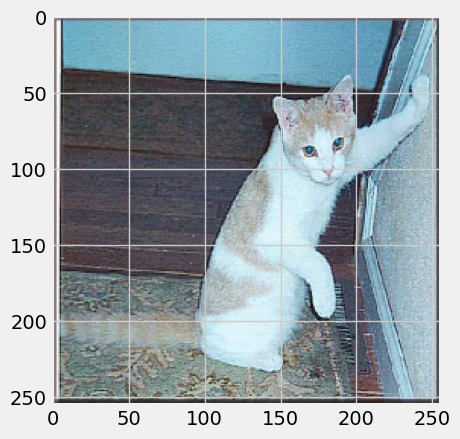

In [86]:
# Diretórios do dataset
train_data_dir = '/root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/training_set/training_set'
test_data_dir = '/root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/test_set/test_set'

sample = '/root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1/test_set/test_set/cats/cat.4001.jpg'
sample = skimage.io.imread(sample)
sample = skimage.transform.resize(sample, (256, 256))
plt.imshow(sample)
plt.show()

In [160]:
# Transformações (inclui normalização)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona as imagens
    transforms.ToTensor(),         # Converte para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza
])

In [161]:
# Carregando os datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)

In [162]:
test_dataset[0][0].shape, test_dataset[0][1]

(torch.Size([3, 128, 128]), 0)

In [164]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [165]:
# Classes do dataset
classes = train_dataset.classes
print(f"Classes: {classes}")

Classes: ['cats', 'dogs']


In [166]:
temp_loader = DataLoader(train_dataset, batch_size=32)

In [167]:
@staticmethod
def statistics_per_channel(images, labels):
    # NCHW
    n_samples, n_channels, n_height, n_weight = images.size()
    # Flatten HW into a single dimension
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)

    # Computes statistics of each image per channel
    # Average pixel value per channel
    # (n_samples, n_channels)
    means = flatten_per_channel.mean(axis=2)
    # Standard deviation of pixel values per channel
    # (n_samples, n_channels)
    stds = flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini-batch
    # (1, n_channels)
    sum_means = means.sum(axis=0)
    sum_stds = stds.sum(axis=0)
    # Makes a tensor of shape (1, n_channels)
    # with the number of samples in the mini-batch
    n_samples = torch.tensor([n_samples]*n_channels).float()

    # Stack the three tensors on top of one another
    # (3, n_channels)
    return torch.stack([n_samples, sum_means, sum_stds], axis=0)

setattr(StepByStep, 'statistics_per_channel', statistics_per_channel)

In [168]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[32.0000, 32.0000, 32.0000],
        [ 0.9935,  1.5523,  3.3821],
        [31.1885, 31.4142, 31.2617]])

In [169]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[8005.0000, 8005.0000, 8005.0000],
        [ 114.1492,  -32.2587,  405.6321],
        [7797.8428, 7789.6338, 7772.1567]])

In [170]:
@staticmethod
def make_normalizer(loader):
    total_samples, total_means, total_stds = StepByStep.loader_apply(loader, StepByStep.statistics_per_channel)
    norm_mean = total_means / total_samples
    norm_std = total_stds / total_samples
    return Normalize(mean=norm_mean, std=norm_std)

setattr(StepByStep, 'make_normalizer', make_normalizer)

In [171]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.0143), tensor(-0.0040), tensor(0.0507)], std=[tensor(0.9741), tensor(0.9731), tensor(0.9709)], inplace=False)

# The Real Datasets

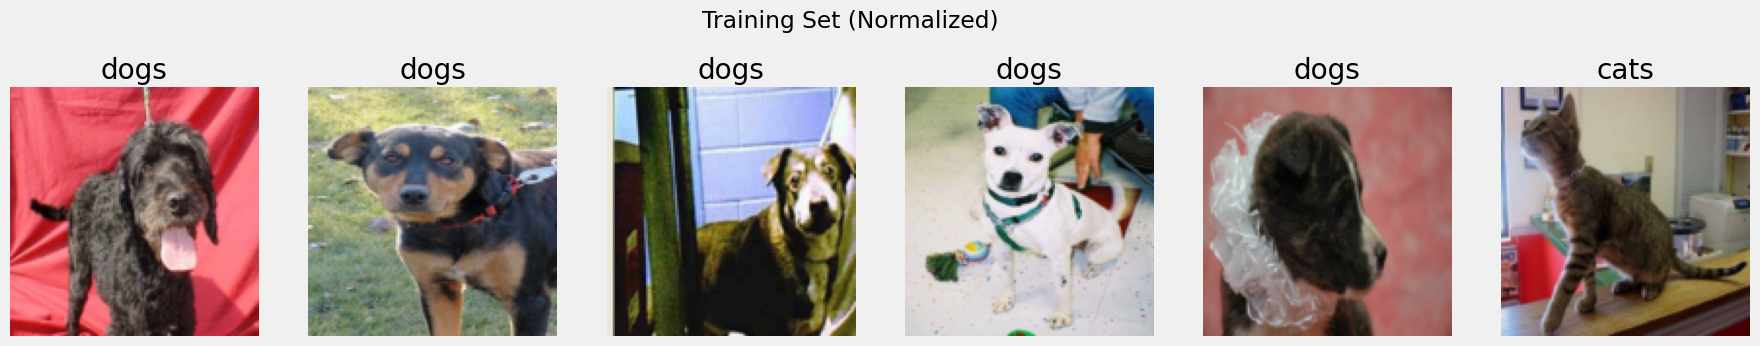

In [172]:
# Função para denormalizar as imagens
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Exibindo algumas amostras
def show_samples(loader, mean, std, classes, title):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:6]  # Seleciona as primeiras 6 imagens
    labels = labels[:6]

    fig, axes = plt.subplots(1, 6, figsize=(20, 4))
    for i in range(6):
        img = denormalize(images[i], mean, std).permute(1, 2, 0).numpy()  # Denormaliza e converte para formato de imagem
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
show_samples(train_loader, mean, std, classes, "Training Set (Normalized)")

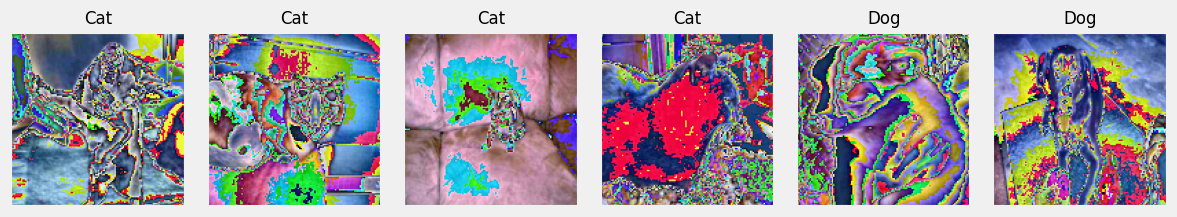

In [173]:
torch.manual_seed(55)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

# Convolutions Over Multiple Channels

In [174]:
regions = np.array([[[[4, 0, 7],
                      [0, 8, 4],
                      [5, 0, 1]],
                     [[0, 4, 3],
                      [7, 0, 8],
                      [3, 7, 0]],
                     [[3, 1, 0],
                      [5, 2, 0],
                      [4, 1, 7]]]])
regions.shape

(1, 3, 3, 3)

In [175]:
three_channel_filter = np.array([[[[1, 4, 1],
                                   [2, 1, 2],
                                   [3, 2, 1]],
                                  [[3, 2, 1],
                                   [1, 4, 5],
                                   [2, 0, 1]],
                                  [[1, 2, 4],
                                   [0, -1, 1],
                                   [3, 1, 2]]]])
three_channel_filter.shape

(1, 3, 3, 3)

In [176]:
result = F.conv2d(torch.as_tensor(regions), torch.as_tensor(three_channel_filter))
result, result.shape

(tensor([[[[137]]]]), torch.Size([1, 1, 1, 1]))

# Fancier Model

In [177]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        # Calculate the correct input size for fc1
        self.fc1 = nn.Linear(n_feature * 60 * 60, 50)  # Changed input size
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        # Adjust max_pool2d to get the correct output size
        x = F.max_pool2d(x, kernel_size=2, stride=1)  # Changed stride to 1
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Dropout

In [178]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))
spaced_points = torch.linspace(.1, 1.5, 15)
spaced_points

torch.manual_seed(55)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.2000, 0.0000, 0.6000, 0.8000, 0.0000, 1.2000, 0.0000, 1.6000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 2.8000, 0.0000])

In [179]:
output_train / spaced_points
F.linear(output_train, weight=torch.ones(15), bias=torch.tensor(0))

dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

F.linear(output_eval, weight=torch.ones(15), bias=torch.tensor(0))

torch.manual_seed(55)
p = 0.5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                         weight=torch.ones(15), bias=torch.tensor(0))
                                for _ in range(1000)])

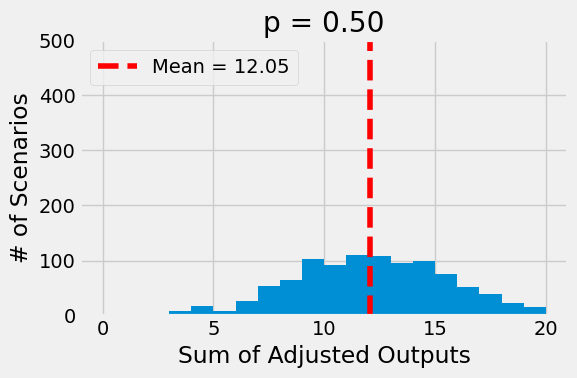

In [180]:
fig = figure7(p, distrib_outputs)

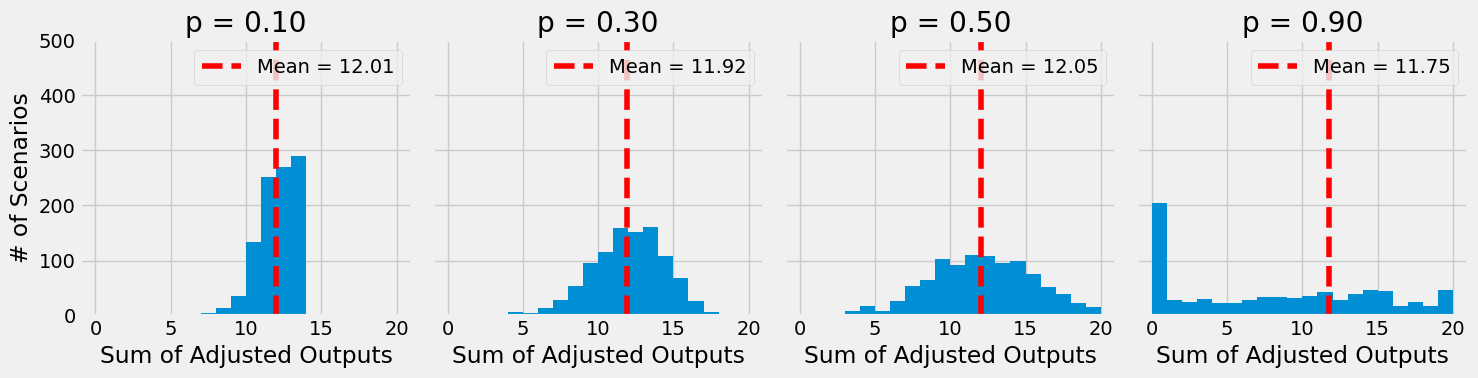

In [181]:
def figure8(ps=(0.1, 0.3, 0.5, 0.9)):
    spaced_points = torch.linspace(.1, 1.5, 15)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for ax, p in zip(axs.flat, ps):
        torch.manual_seed(55)
        distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                                 weight=torch.ones(15), bias=torch.tensor(0))
                                        for _ in range(1000)])
        plot_dist(ax, distrib_outputs, p)
        ax.label_outer()
    fig.tight_layout()
    return fig

fig = figure8()

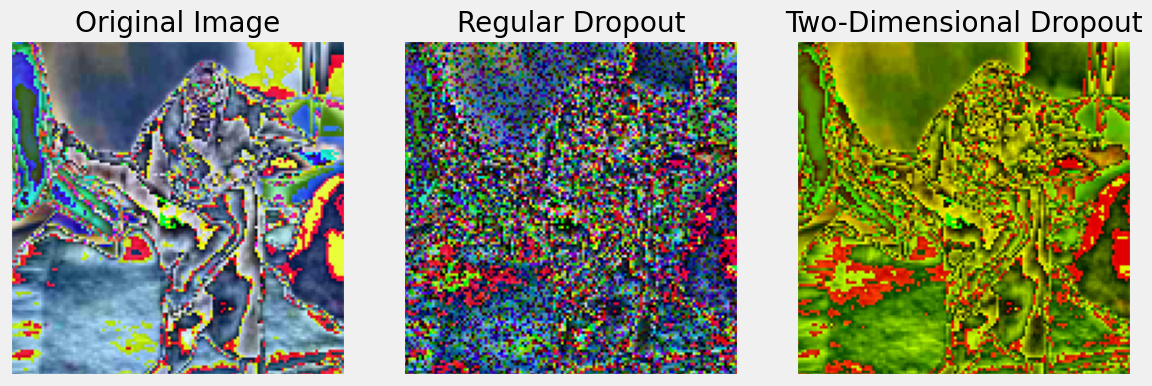

In [182]:
fig = figure9(first_images)

# Model Configuration

In [183]:
torch.manual_seed(55)
model_cnn2 = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

# Model Training

In [184]:
sbs_cnn2 = StepByStep(model_cnn2, multi_loss_fn, optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader, test_loader)
sbs_cnn2.train(10)

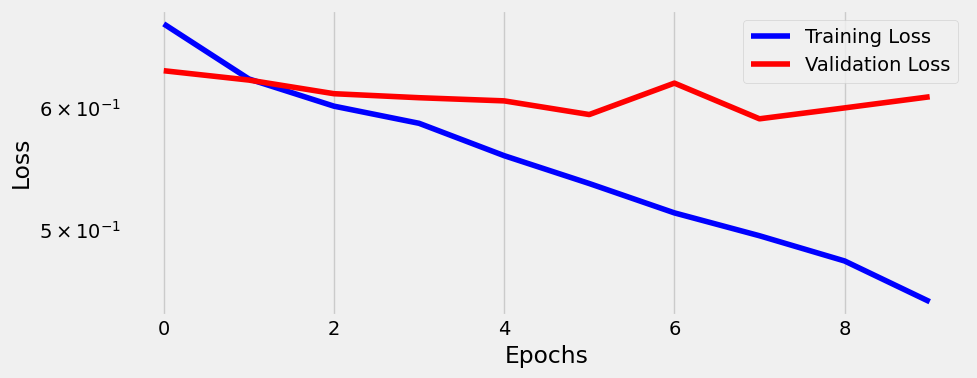

In [185]:
fig = sbs_cnn2.plot_losses()

# Accuracy

In [186]:
StepByStep.loader_apply(test_loader, sbs_cnn2.correct)

tensor([[ 715, 1011],
        [ 706, 1012],
        [   0,    0]])

# Regularizing Effect

In [187]:
torch.manual_seed(55)
# Model Configuration
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)
# Model Training
sbs_cnn2_nodrop = StepByStep(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
sbs_cnn2_nodrop.set_loaders(train_loader, test_loader)
sbs_cnn2_nodrop.train(10)

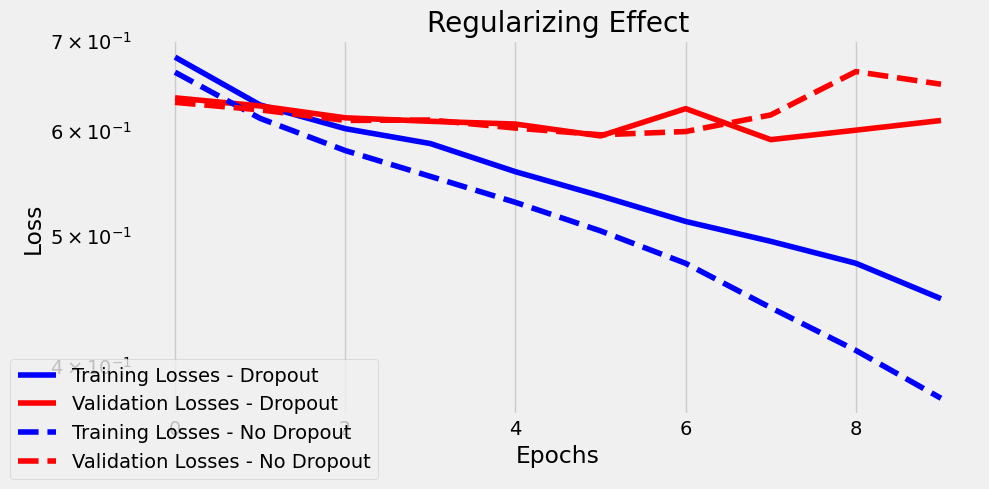

In [188]:
fig = figure11(sbs_cnn2.losses, sbs_cnn2.val_losses, sbs_cnn2_nodrop.losses, sbs_cnn2_nodrop.val_losses)

In [189]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2_nodrop.correct).sum(axis=0),
    StepByStep.loader_apply(test_loader, sbs_cnn2_nodrop.correct).sum(axis=0)
)

tensor([6954, 8005]) tensor([1407, 2023])


In [190]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2.correct).sum(axis=0),
    StepByStep.loader_apply(test_loader, sbs_cnn2.correct).sum(axis=0)
)

tensor([6661, 8005]) tensor([1421, 2023])


# Visualizing Filters

In [191]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

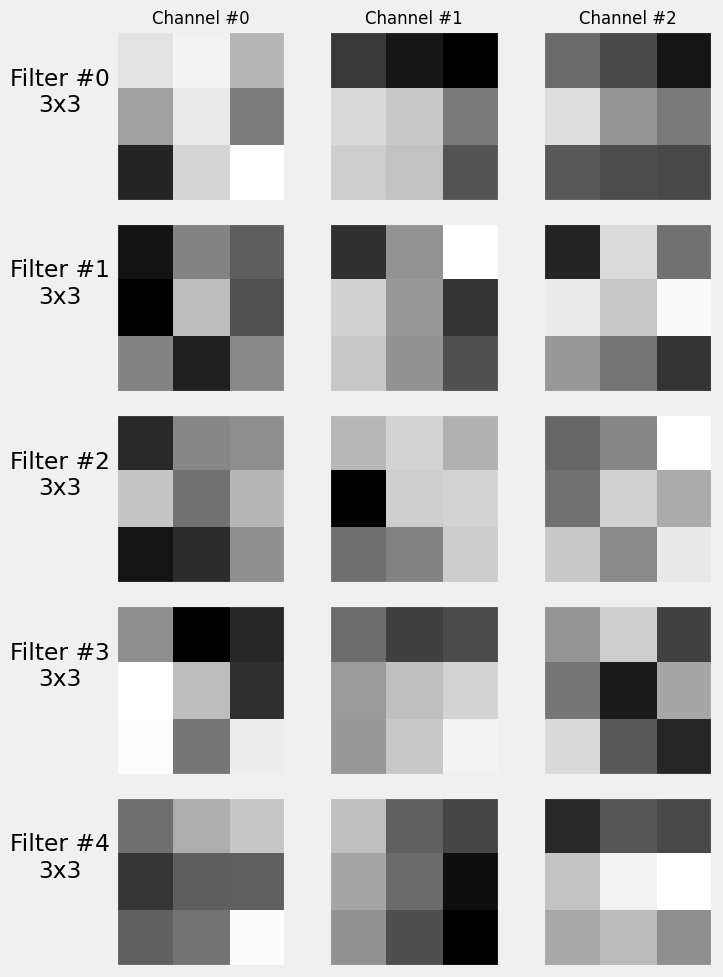

In [192]:
ig = sbs_cnn2.visualize_filters('conv1')

In [193]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

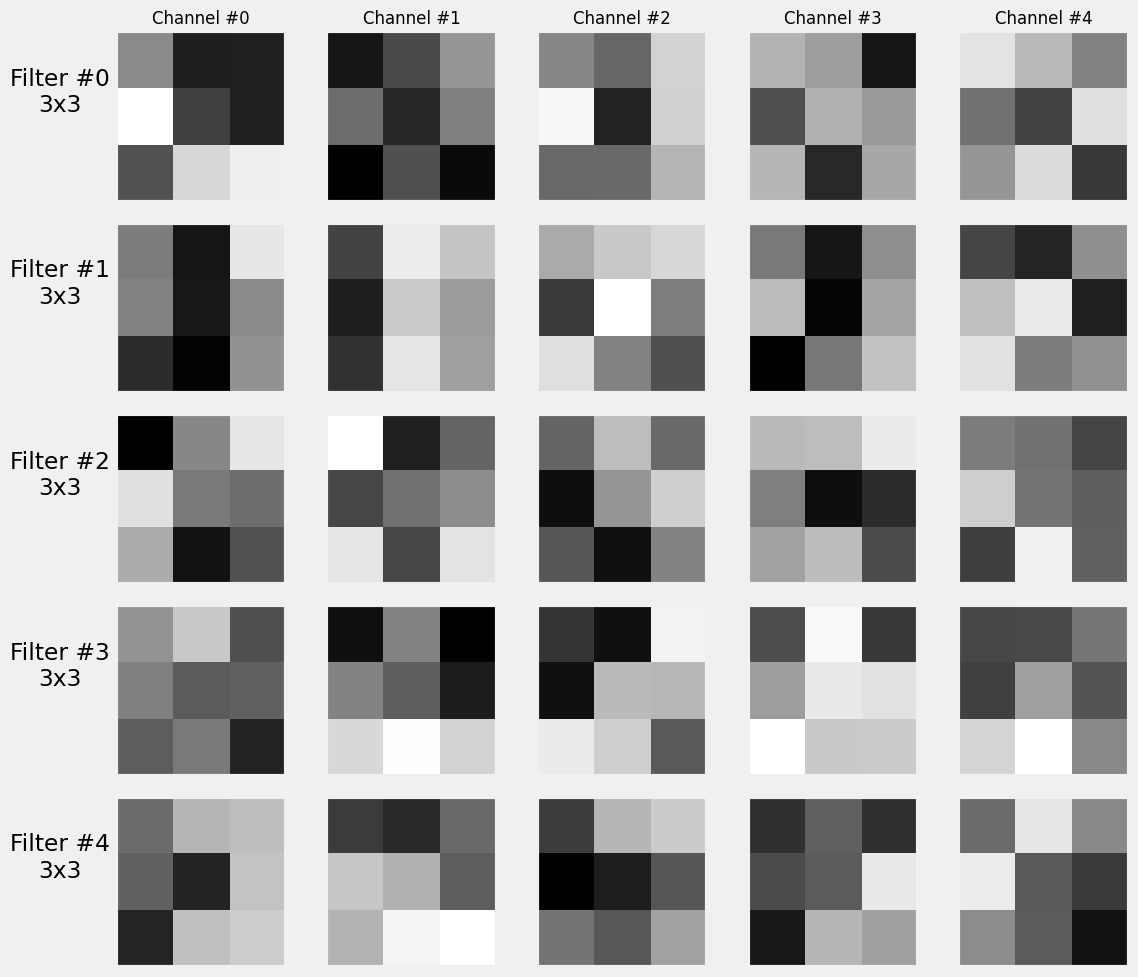

In [194]:
fig = sbs_cnn2.visualize_filters('conv2')

# Learning Rates

## Finding LR

In [196]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

In [197]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp')

In [198]:
lr_fn(np.arange(num_iter + 1))

array([ 1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

In [199]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

In [200]:
dummy_model = CNN2(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

In [201]:
dummy_optimizer.step()
dummy_scheduler.step()

In [202]:
dummy_scheduler.get_last_lr()[0]

0.012589254117941673

In [203]:
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

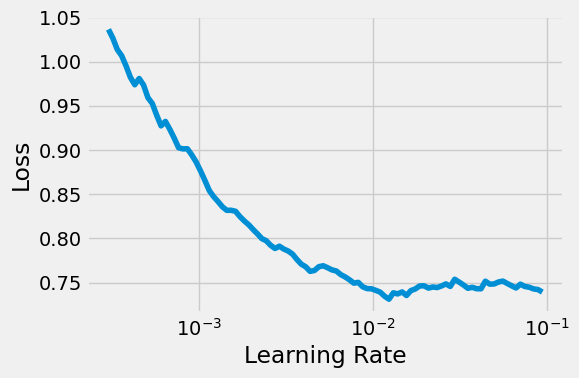

In [204]:
sbs_new = StepByStep(new_model, multi_loss_fn, new_optimizer)
tracking, fig = sbs_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [205]:
def set_optimizer(self, optimizer):
    self.optimizer = optimizer

setattr(StepByStep, 'set_optimizer', set_optimizer)

In [206]:
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader, test_loader)
sbs_new.train(10)

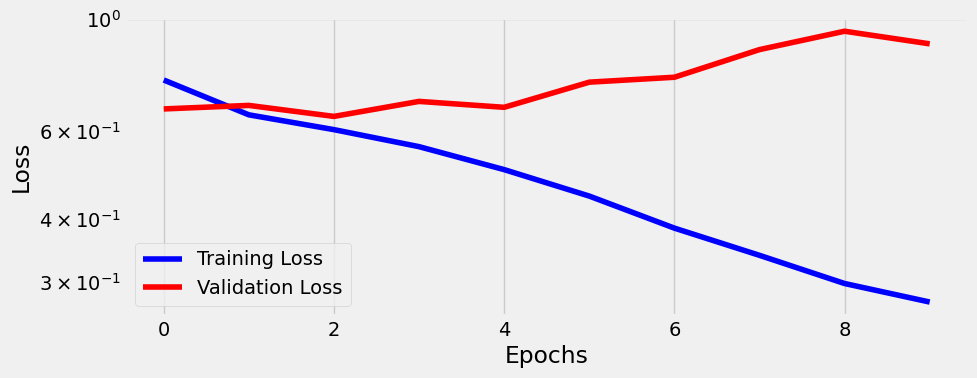

In [207]:
# This plot wasn't included in the book
fig = sbs_new.plot_losses()

## LRFinder


In [208]:
!pip install --quiet torch-lr-finder
from torch_lr_finder import LRFinder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.43E-04


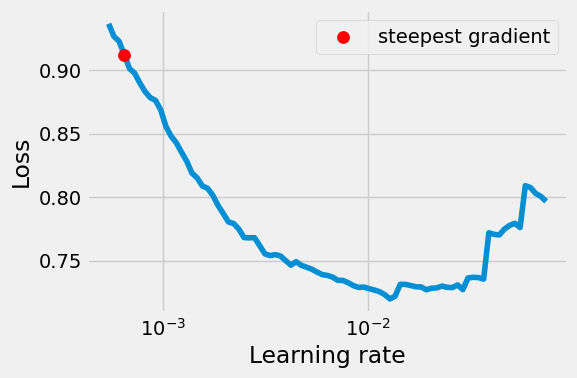

# Adaptive Learning Rate

### Moving Average (MA)

$$
\large
\text{MA}_t(\text{periods}, x) = \frac{1}{\text{periods}}(x_t + x_{t-1} + \ldots + x_{t-\text{periods}+1})
$$

$$
\large
\text{average age}_{\text{MA}} = \frac{1+2+\cdots+\text{periods}}{\text{periods}} = \frac{\text{periods}+1}{2}
$$

In [209]:
alpha = 1/3; T = 93
t = np.arange(1, T + 1)
age = alpha * sum((1 - alpha)**(t - 1) * t)
age

3.0

In [210]:
def EWMA(past_value, current_value, alpha):
    return (1 - alpha) * past_value + alpha * current_value

In [211]:
def calc_ewma(values, period):
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

In [212]:
def correction(averaged_value, beta, steps):
    return averaged_value / (1 - (beta ** steps))

In [213]:
def calc_corrected_ewma(values, period):
    ewma = calc_ewma(values, period)

    alpha = 2 / (period + 1)
    beta = 1 - alpha

    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)

    return np.array(result)

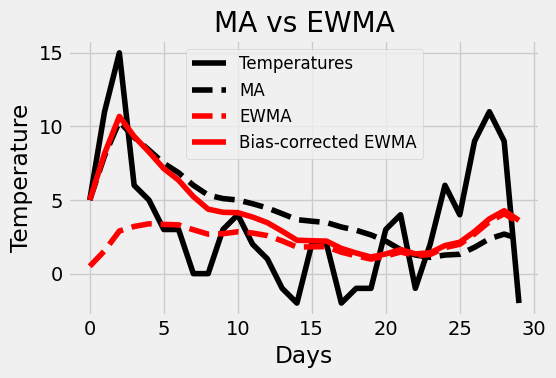

In [214]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1,
    -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])

fig = ma_vs_ewma(temperatures, periods=19)

# Adam

In [215]:
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.0125, betas=(0.9, 0.999), eps=1e-8)

In [216]:
#%run -i data_generation/simple_linear_regression.py

import numpy as np

true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (.1 * np.random.randn(N, 1))

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]


In [217]:
# %run -i data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [218]:
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')

In [219]:
setattr(StepByStep, '_gradients', {})

def capture_gradients(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    self._gradients = {}

    def make_log_fn(name, parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return
        return log_fn

    for name, layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name: {}})
            for parm_id, p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id: []})
                    log_fn = make_log_fn(name, parm_id)
                    self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
    return

setattr(StepByStep, 'capture_gradients', capture_gradients)

In [221]:
sbs_adam = StepByStep(model, loss_fn, optimizer)
sbs_adam.set_loaders(train_loader, val_loader)
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()

In [222]:
gradients = np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

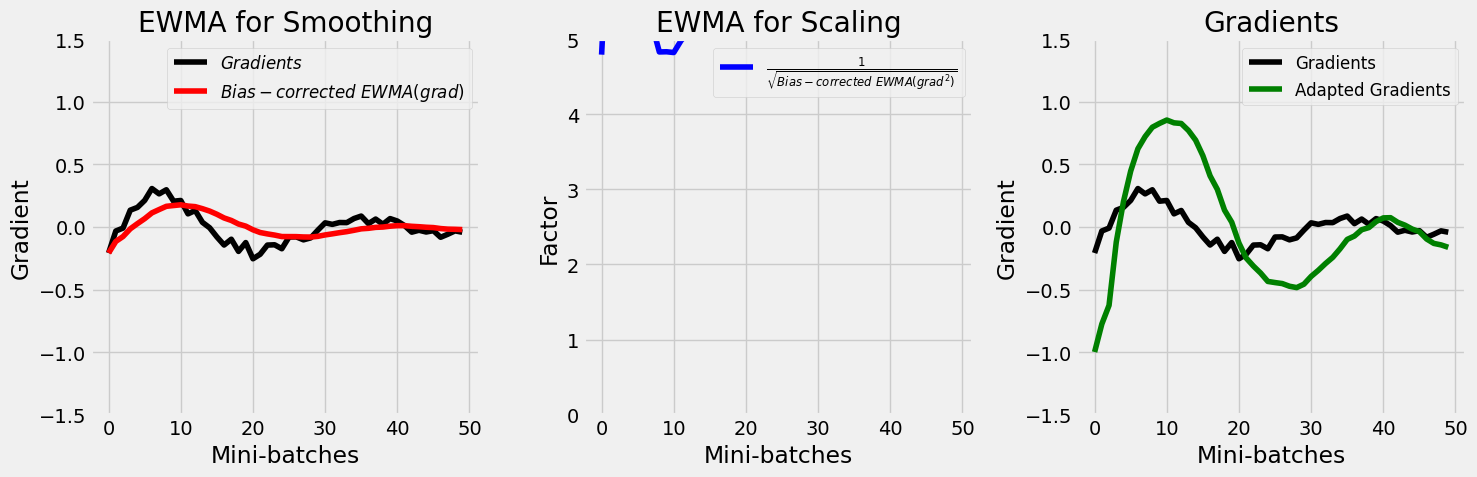

In [223]:
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

In [224]:
optimizer.state_dict()

{'state': {0: {'step': tensor(55.),
   'exp_avg': tensor([[-0.0223]]),
   'exp_avg_sq': tensor([[0.0033]])},
  1: {'step': tensor(55.),
   'exp_avg': tensor([-0.0069]),
   'exp_avg_sq': tensor([0.0094])}},
 'param_groups': [{'lr': 0.1,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

In [225]:
calc_ewma(gradients, 19)[-1], calc_ewma(np.power(gradients, 2), 1999)[-1]

(-0.021041725197257923, 0.0008241713853405118)

In [231]:
setattr(StepByStep, '_parameters', {})

def capture_parameters(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules}

    self._parameters = {}

    for name, layer in modules:
        if name in layers_to_hook:
            self._parameters.update({name: {}})
            for parm_id, p in layer.named_parameters():
                self._parameters[name].update({parm_id: []})

    def fw_hook_fn(layer, inputs, outputs):
        name = layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())

    self.attach_hooks(layers_to_hook, fw_hook_fn)
    return

setattr(StepByStep, 'capture_parameters', capture_parameters)

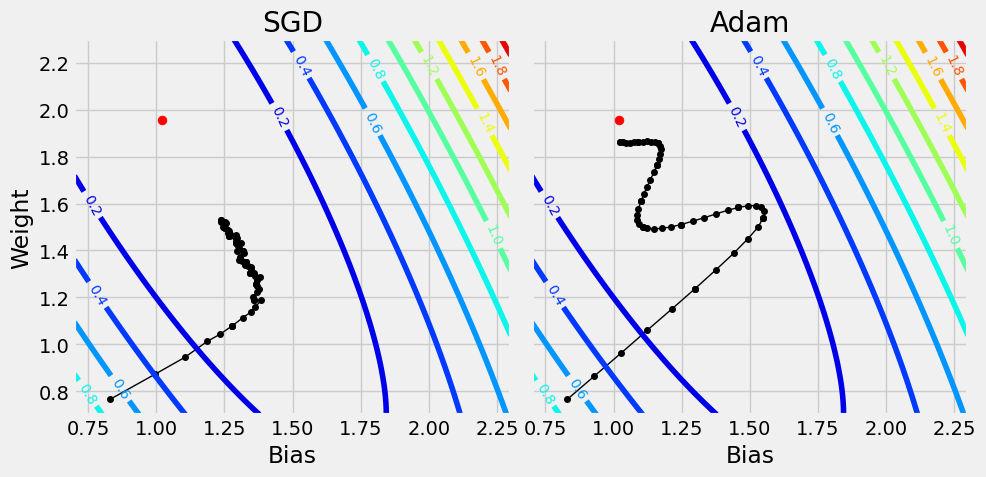

In [236]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
             'Adam': {'class': optim.Adam, 'parms': {'lr': 0.1}}}
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)
fig = plot_paths(results, b, w, bs, ws, all_losses)

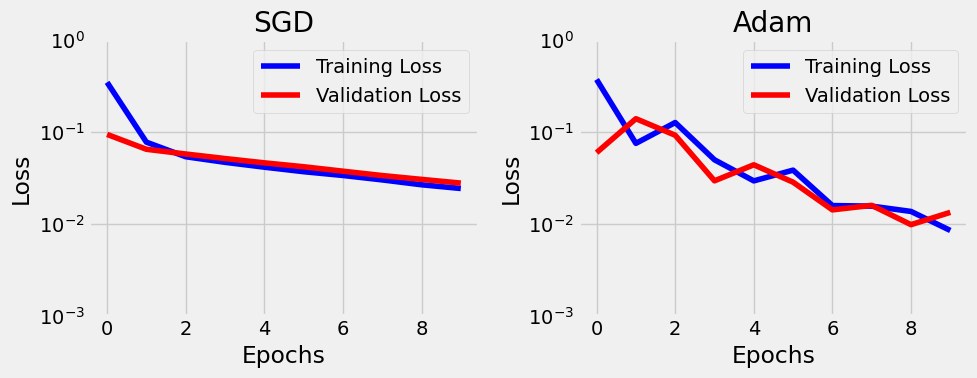

In [237]:
fig = plot_losses(results)

### Momentum

In [238]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
             'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

In [239]:
results['SGD + Momentum']['state']

{'state': {0: {'momentum_buffer': tensor([[-0.0308]])},
  1: {'momentum_buffer': tensor([-0.1423])}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

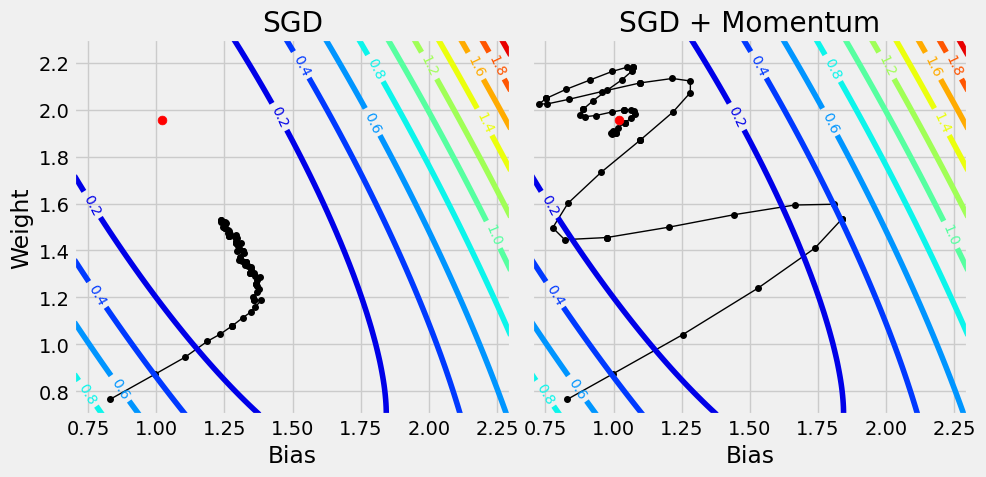

In [240]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

#### Nesterov

In [241]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
              'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

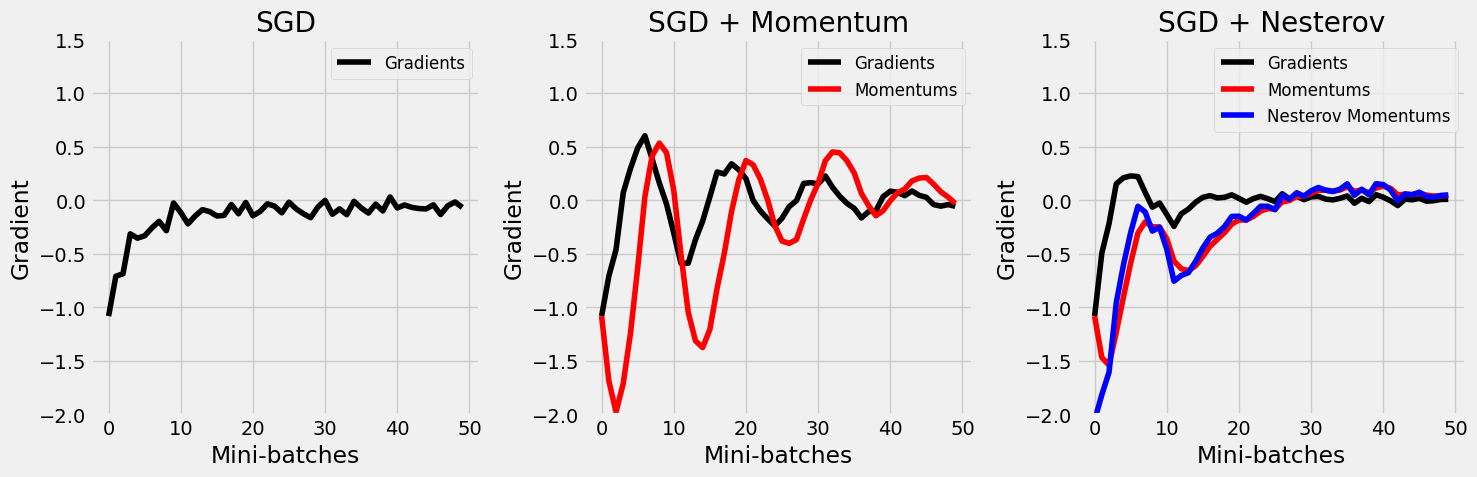

In [242]:
fig = figure21(results)

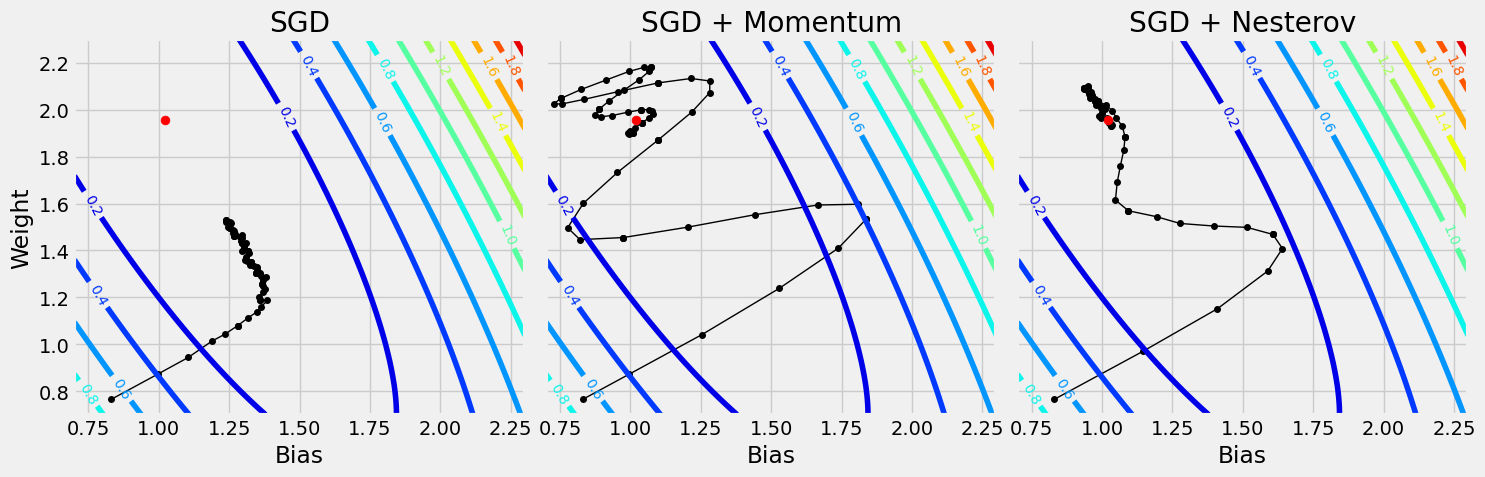

In [243]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

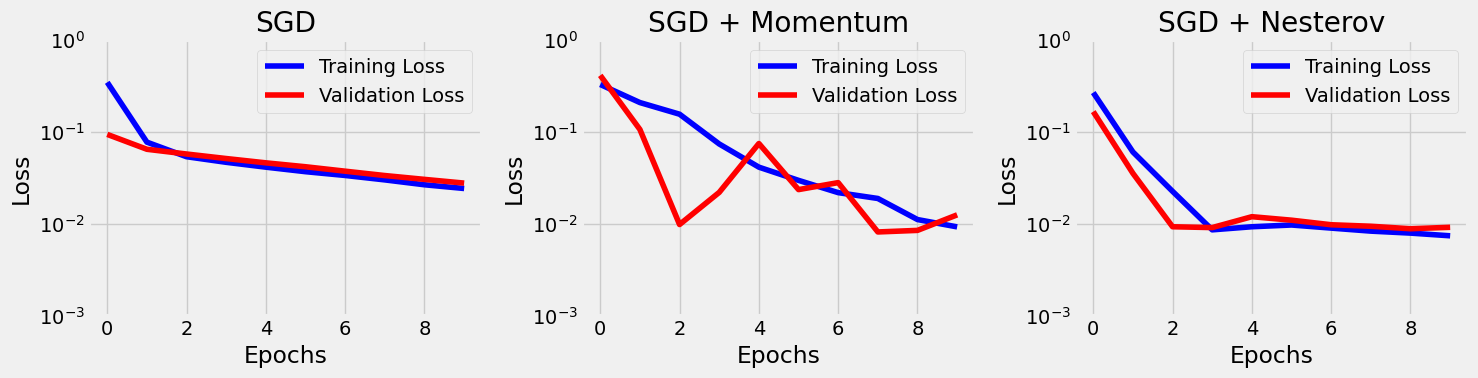

In [244]:
fig = plot_losses(results)

### Learning Rate Schedulers

In [245]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

In [246]:
for epoch in range(4):
    # trainin loop code goes here

    print(dummy_scheduler.get_last_lr())
    # First call optimizer's step
    dummy_optimizer.step()
    # Then call scheduler's step
    dummy_scheduler.step()

    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


### Epoch Schedulers

In [247]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))
# The scheduler above is equivalent to this one
# dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

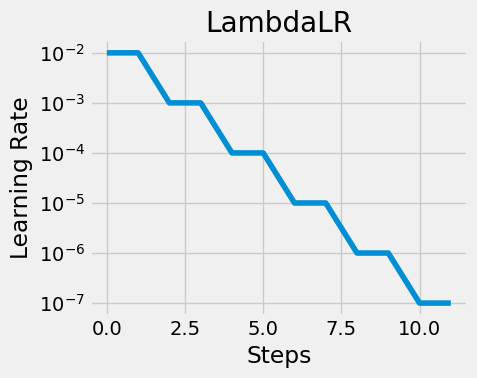

In [248]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

In [249]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
#dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))
# The scheduler above is equivalent to this one
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

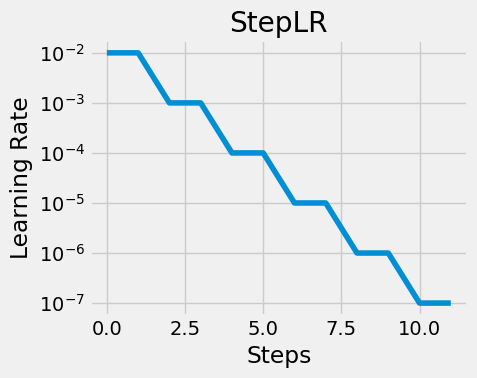

In [250]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Validation Loss Scheduler

In [251]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

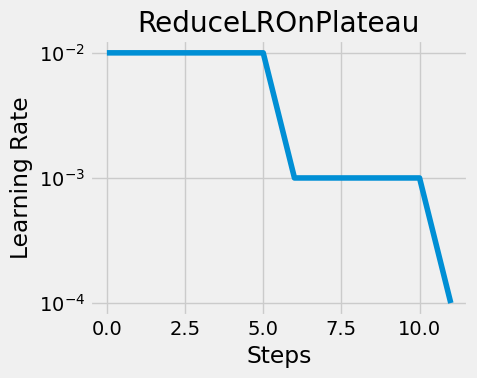

In [252]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Scheduler in StepByStep - Part I

In [253]:
setattr(StepByStep, 'scheduler', None)
setattr(StepByStep, 'is_batch_lr_scheduler', False)

def set_lr_scheduler(self, scheduler):
    # Makes sure the scheduler in the argument is assigned to the
    # optimizer we're using in this class
    if scheduler.optimizer == self.optimizer:
        self.scheduler = scheduler
        if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
            isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
            isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
            self.is_batch_lr_scheduler = True
        else:
            self.is_batch_lr_scheduler = False

setattr(StepByStep, 'set_lr_scheduler', set_lr_scheduler)

In [254]:
setattr(StepByStep, 'learning_rates', [])

def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_epoch_schedulers', _epoch_schedulers)

In [255]:
def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        self._epoch_schedulers(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under the main tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Closes the writer
        self.writer.close()

setattr(StepByStep, 'train', train)

### Mini-Batch Schedulers

In [256]:
dummy_parm = [nn.Parameter(torch.randn(1))]
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular')
dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular2')
dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(.5))

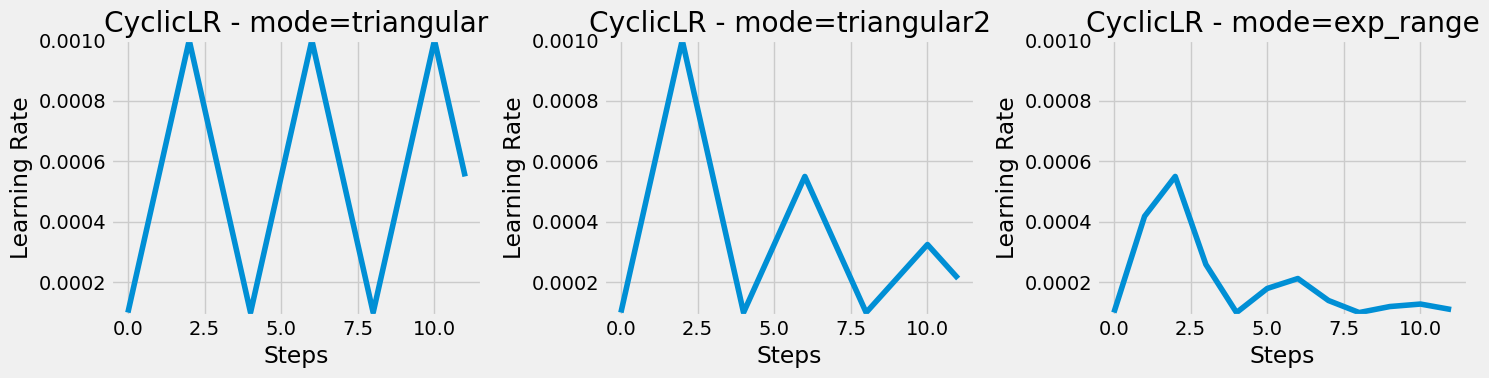

In [257]:
fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

### Schedulers in StepByStep - Part II

In [258]:
def _mini_batch_schedulers(self, frac_epoch):
    if self.scheduler:
        if self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                self.scheduler.step(self.total_epochs + frac_epoch)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_mini_batch_schedulers', _mini_batch_schedulers)

In [259]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    n_batches = len(data_loader)
    # Once the data loader and step function, this is the same
    # mini-batch loop we had before
    mini_batch_losses = []
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

        if not validation:
            self._mini_batch_schedulers(i / n_batches)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

### Scheduler Paths

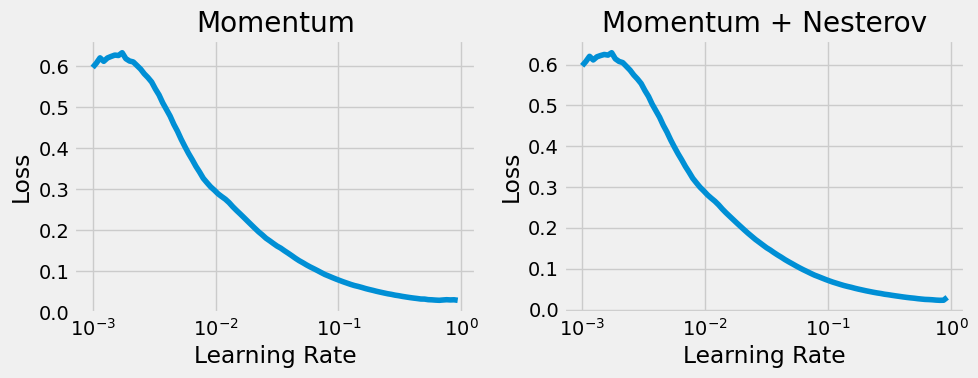

In [261]:
#from stepbystep.v3 import StepByStep

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, nesterov in zip(axs.flat, [False, True]):
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=nesterov)

    sbs_scheduler = StepByStep(model, loss_fn, optimizer)
    tracking, fig = sbs_scheduler.lr_range_test(train_loader, end_lr=1, num_iter=100, ax=ax)

    nest = ' + Nesterov' if nesterov else ''
    ax.set_title(f'Momentum{nest}')

In [262]:
step_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
cyclic_scheduler = CyclicLR(optimizer, base_lr=0.025, max_lr=0.1, step_size_up=10, mode='triangular2')

In [263]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)

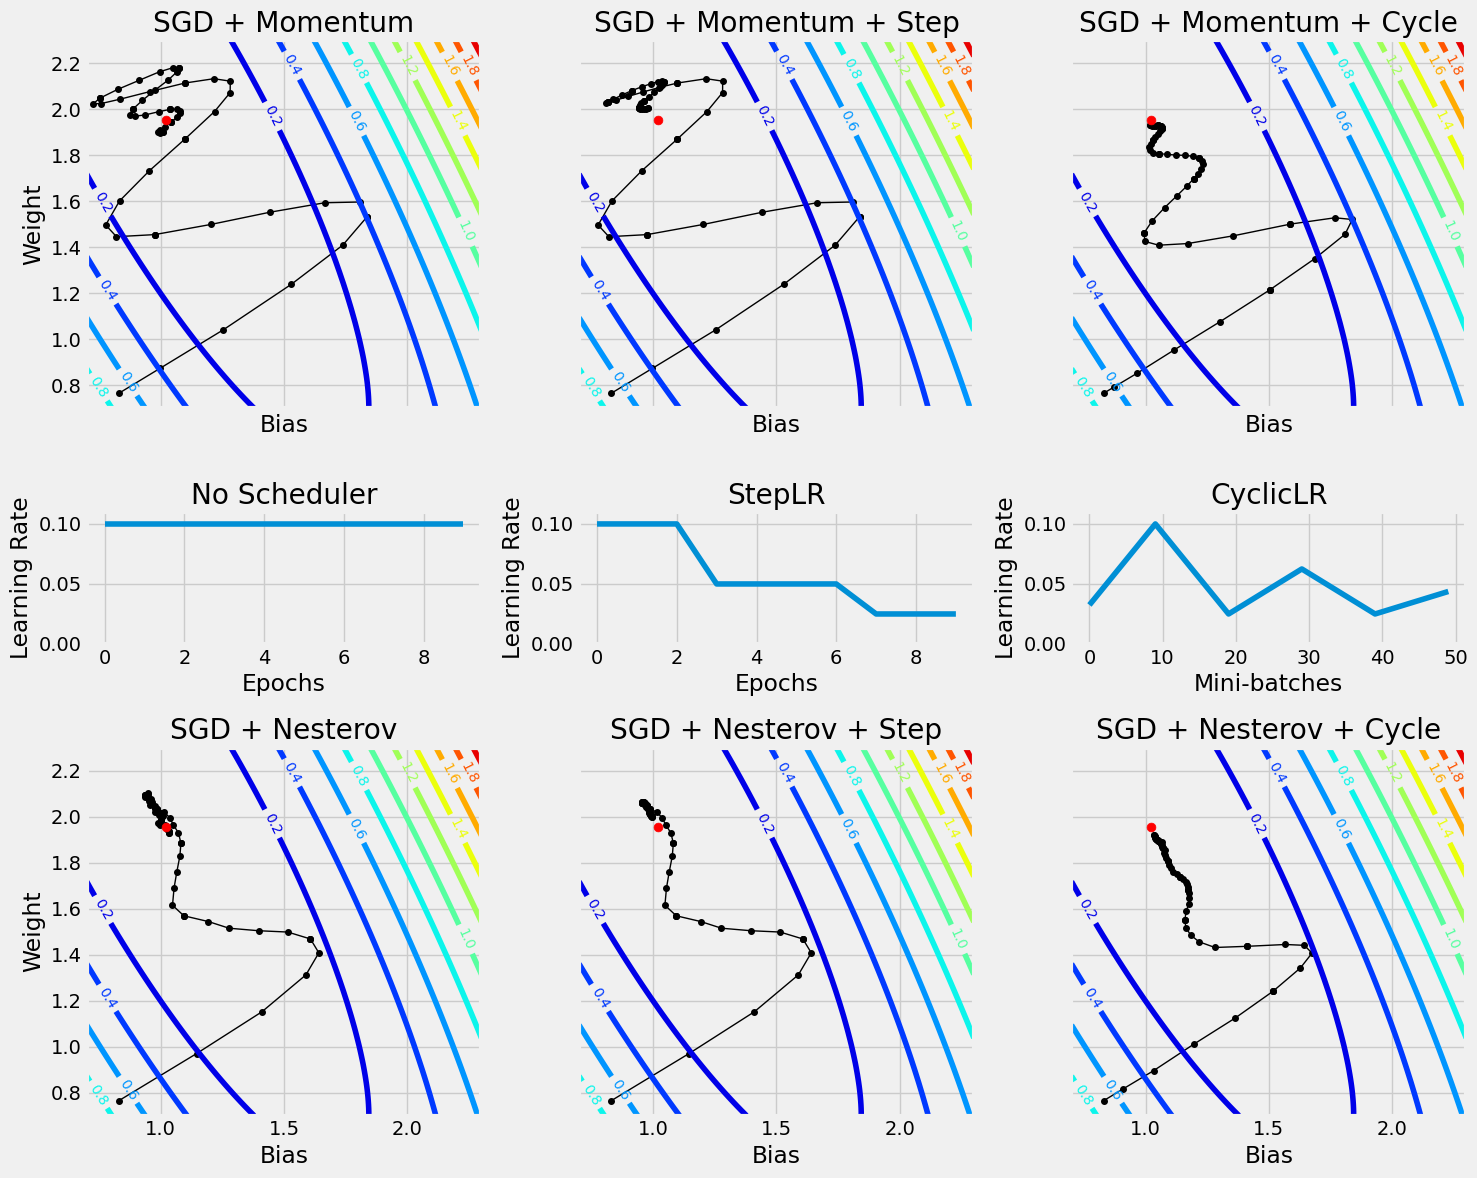

In [264]:
fig = figure28(results, b, w, bs, ws, all_losses)

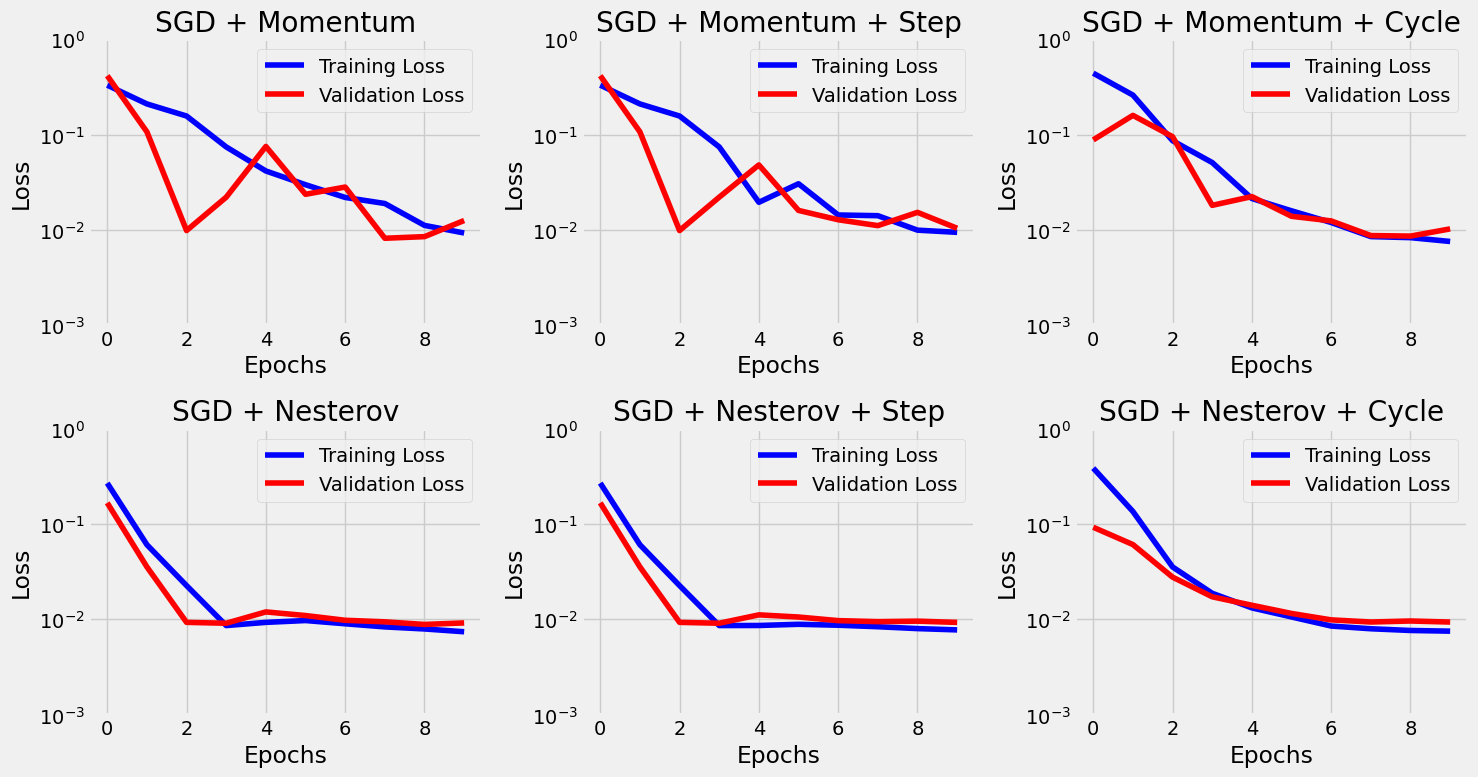

In [265]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flat
fig = plot_losses(results, axs)

# Putting It All Together

In [266]:
import torchvision.transforms as transforms

# Transformações (inclui normalização)
temp_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona as imagens
    transforms.ToTensor(),         # Converte para tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza
])

# Loads temporary dataset to build normalizer
# temp_transform = Compose([Resize(28), ToImage(), ToDtype(torch.float32, scale=True)])
temp_dataset = ImageFolder(root=train_data_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=32)
normalizer = StepByStep.make_normalizer(temp_loader)

# Transformações (inclui normalização)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona as imagens
    transforms.ToTensor(),         # Converte para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza
])

train_data = ImageFolder(root=train_data_dir, transform=transform)
val_data = ImageFolder(root=test_data_dir, transform=transform)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [267]:
torch.manual_seed(13)
model_cnn3 = CNN2(n_feature=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

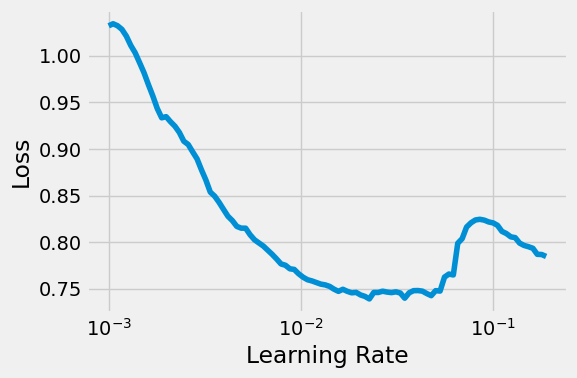

In [268]:
sbs_cnn3 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn3)
tracking, fig = sbs_cnn3.lr_range_test(train_loader, end_lr=2e-1, num_iter=100)

In [269]:
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)
sbs_cnn3.set_optimizer(optimizer_cnn3)

scheduler = CyclicLR(optimizer_cnn3, base_lr=1e-3, max_lr=0.01, step_size_up=len(train_loader), mode='triangular2')
sbs_cnn3.set_lr_scheduler(scheduler)

In [270]:
sbs_cnn3.set_loaders(train_loader, test_loader)
sbs_cnn3.train(10)

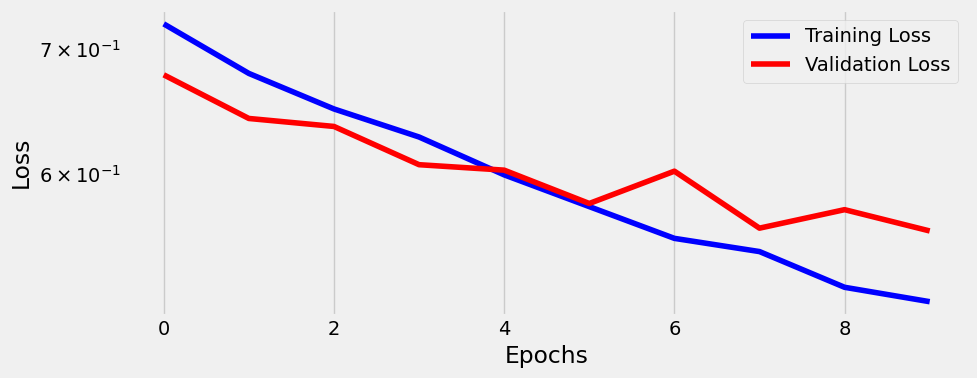

In [271]:
fig = sbs_cnn3.plot_losses()

In [272]:
print(StepByStep.loader_apply(train_loader, sbs_cnn3.correct).sum(axis=0),
      StepByStep.loader_apply(test_loader, sbs_cnn3.correct).sum(axis=0))

tensor([6362, 8005]) tensor([1462, 2023])
